# Titanic Dataset Training with GP

### General Useful Packages:
- **numpy**: Provides support for large, multi-dimensional arrays and matrices, and offers a collection of mathematical functions to operate on these arrays.
- **pandas**: A powerful data manipulation library for structured data, providing data frames for data storage and operations like filtering, aggregating, and merging.
- **random**: Implements pseudo-random number generators for various distributions, useful for random selections and simulations.
- **operator**: Provides functional equivalents to common Python operators, enabling cleaner and faster functional-style programming.
- **matplotlib.pyplot**: A plotting library for creating static, interactive, and animated visualizations in Python, particularly for 2D graphs.

### Preprocessing and Metrics:
- **sklearn.model_selection.train_test_split**: A function for splitting data into training and testing sets for machine learning tasks.
- **sklearn.metrics.accuracy_score**: A function for calculating the accuracy of a classification model, comparing predicted labels with the true labels.
- **sklearn.metrics.confusion_matrix**: A function for calculating the confusion matrix

### Genetic Programming Stuff:
- **deap.algorithms**: Contains various algorithms (e.g., genetic algorithm, evolutionary strategies) for optimization tasks.
- **deap.base**: Provides base classes and methods to build evolutionary algorithms, such as individuals, populations, and evolutionary operators.
- **deap.creator**: Allows the creation of custom classes (e.g., individuals, fitness) with inheritance from DEAP’s base classes.
- **deap.tools**: Offers a collection of tools for evolutionary computation, like selection, mutation, and crossover operators.
- **deap.gp**: Provides functionalities for Genetic Programming (GP), allowing tree-based structures for evolving expressions or solutions.

In [1]:
# General Useful Packages
import numpy as np
import pandas as pd
import random
import operator
import matplotlib.pyplot as plt

# Preprocessing and Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Genetic Programming Stuff
from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

Load the training data from `train.csv` and show original data

In [2]:
train_data = pd.read_csv("train.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**Preprocess the data**

- Drop: Name, Ticket, Cabin 

- Transform: (Sex-> Male:0, Female:1), (Embarked-> S:0, C:1, Q:2)

- N/A Values: Replace with Mean

In [3]:
train_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True) # Drop 
train_data['Sex'] = train_data['Sex'].map({'male': 0, 'female': 1})
train_data['Embarked'] = train_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
train_data.fillna(train_data.mean(), inplace=True) 
train_data

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0,3,0,22.000000,1,0,7.2500,0.0
1,2,1,1,1,38.000000,1,0,71.2833,1.0
2,3,1,3,1,26.000000,0,0,7.9250,0.0
3,4,1,1,1,35.000000,1,0,53.1000,0.0
4,5,0,3,0,35.000000,0,0,8.0500,0.0
...,...,...,...,...,...,...,...,...,...
886,887,0,2,0,27.000000,0,0,13.0000,0.0
887,888,1,1,1,19.000000,0,0,30.0000,0.0
888,889,0,3,1,29.699118,1,2,23.4500,0.0
889,890,1,1,0,26.000000,0,0,30.0000,1.0


**Declare Feature and Target Variables**
- Features = Pclass, Sex, Age, SibSp, Parch, Fare, Embarked
- Target = Survived

In [4]:
X = train_data.drop(columns=['PassengerId', 'Survived'])
y = train_data['Survived']

#
- Split Data: 90% Train
- 10% Test on Train.csv 
- Random State is 20


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=20)

# Set Up the Primitive Set
Defines the type of inputs and arguments

Create fitness and individual classes. The invidiual class inherits DEAP's PrimitiveTree class. This is the most common in GP Trees. They are made of functions and varaibles called primitives. Each primitive is a node in the ree where the leaves of a node are the inputs. Evaluate each invidiaul by compiling the pirmtiive tree from its leave to its root node.

In [6]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0, -1.0))  # Minimize FP and FN
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

Initialize the primitive set, add primitive operations (functions), and terminals (Titanic Features). Mathematical operators are added to our primitive set. I also rename the default arguments to the features that my titanic dataset uses.

In [8]:
# Initialize PrimitiveSet
pset = gp.PrimitiveSet("main", 7) 

# Primitive Operations - Loosely Typed GP, no specific types
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(np.sin, 1)
pset.addPrimitive(np.cos, 1)

# Arguments: Pclass, Sex, Age, SibSp, Parch, Fare, Embarked 
pset.addEphemeralConstant("rand101", lambda: random.randint(-1,1))
pset.renameArguments(ARG0="Pclass")
pset.renameArguments(ARG1="Sex")
pset.renameArguments(ARG2="Age")
pset.renameArguments(ARG3="SibSp")
pset.renameArguments(ARG4="Parch")
pset.renameArguments(ARG5="Fare")
pset.renameArguments(ARG6="Embarked")



Define the toolbox, individual, population, and compiler 

In [9]:
# Define Tool Box
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Fitness evaluation function
def evaluate_individual(individual, data, target):
    func = toolbox.compile(expr=individual)
    predictions = [int(func(*row) > 0.5) for row in data]
    
    tn, fp, fn, tp = confusion_matrix(target, predictions).ravel()
    
    # Return both FP and FN for multi-objective optimization
    return fp, fn  # Tuple: (FP, FN)


# Register the evaluation function for multi-objective optimization
toolbox.register("evaluate", evaluate_individual, data=X_train.values, target=y_train.values)
toolbox.register("select", tools.selNSGA2)  
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr, pset=pset)

# Setup population
population = toolbox.population(n=300)
hall_of_fame = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("min", np.min)
stats.register("max", np.max)


Run the evolutionary algorithm

In [10]:
for g in range(200):
    offspring = toolbox.select(population, len(population))
    offspring = list(map(toolbox.clone, offspring))

    for child1, child2 in zip(offspring[::2], offspring[1::2]):
        if random.random() < 0.5:
            toolbox.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    for mutant in offspring:
        if random.random() < 0.2:
            toolbox.mutate(mutant)
            del mutant.fitness.values

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    population[:] = offspring
    fits = [ind.fitness.values for ind in population]

# Select the best individual based on Pareto dominance (multi-objective)
pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

# Compile the best individual (based on Pareto front)
best_individual = pareto_front[0]
best_function = toolbox.compile(expr=best_individual)

# Predict on the test data
y_pred = [int(best_function(*row) > 0.5) for row in X_test.values]

# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")



False Positives (FP): 5
False Negatives (FN): 9


# Pareto Frontier
- Loop through each individual pareto front and store FP and FN values after predicting on y_pred
- Plot after finishing loop

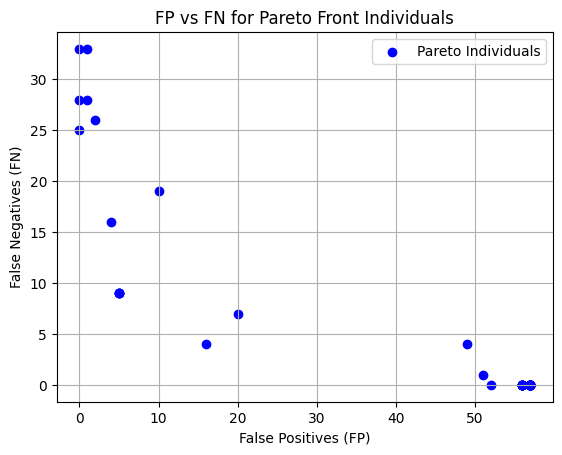

In [11]:
fp_fn_array = [] # arr[i][0] = fp, arr[i][1] = fn

# Loop through every individual in the Pareto front
for ind in pareto_front:

    func = toolbox.compile(expr=ind)
    y_pred = [int(func(*row) > 0.5) for row in X_test.values]
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    fp_fn_array.append([fp, fn])

import numpy as np
fp_fn_array = np.array(fp_fn_array)


plt.scatter(fp_fn_array[:, 0], fp_fn_array[:, 1], c='blue', label='Pareto Individuals')
plt.xlabel('False Positives (FP)')
plt.ylabel('False Negatives (FN)')
plt.title('FP vs FN for Pareto Front Individuals')
plt.legend()
plt.grid(True)
plt.show()

- Load and Preprocess Test Data (same preprocessing as train.csv)
- Compile the best individual (based on Pareto front)
- Make predictions using the best individual
- Output to CSV File

In [34]:
test_data = pd.read_csv("test.csv")
test_data.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
test_data['Sex'] = test_data['Sex'].map({'male': 0, 'female': 1})
test_data['Embarked'] = test_data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test_data.fillna(test_data.mean(), inplace=True)

best_function = toolbox.compile(expr=best_individual)

X_test_final = test_data.drop(columns=['PassengerId'])
predictions = [int(best_function(*row) > 0.5) for row in X_test_final.values]

output = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': predictions})
output.to_csv('genetic_programming.csv', index=False)
